In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from concentrations import concentrations_generator as cg
import ribosomesimulator as r


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
json_path = os.path.abspath('Data/adjusted_basepairing .json')

In [3]:
filenames = os.listdir('Data/tRNA data/')
filenames = [filename for filename in filenames if filename[0] != '.']
filenames = [filename for filename in filenames if filename[0] != 'c']

tRNA_data = pd.read_csv('Data/tRNA data/' + filenames[0])
new_name_0 = filenames[0].split('_')[1]
colnames = list(tRNA_data.columns[:-1])
colnames.append(new_name_0)
tRNA_data.columns = colnames
for filename in filenames:
    new_data = pd.read_csv('Data/tRNA data/' + filename)
    new_name = filename.split('_')[1]
    if new_name != new_name_0:
        new_colnames = list(new_data.columns[:-1])
        new_colnames.append(new_name)
        new_data.columns = new_colnames
        tRNA_data = tRNA_data.merge(new_data[['anticodon.dna',new_name]],on='anticodon.dna')  

plot_data = pd.DataFrame(tRNA_data['anticodon.dna'])
for colname in tRNA_data.columns[3:]:
    col_max = np.mean(tRNA_data[colname])
    plot_data[colname] = tRNA_data[colname] / col_max
plot_data = plot_data[['anticodon.dna','GCN','mimSeq','QuantMSeq','Nanopore','ARMSeq','HydroSeq','ncSeq']]


plot_data = plot_data.set_index('anticodon.dna')

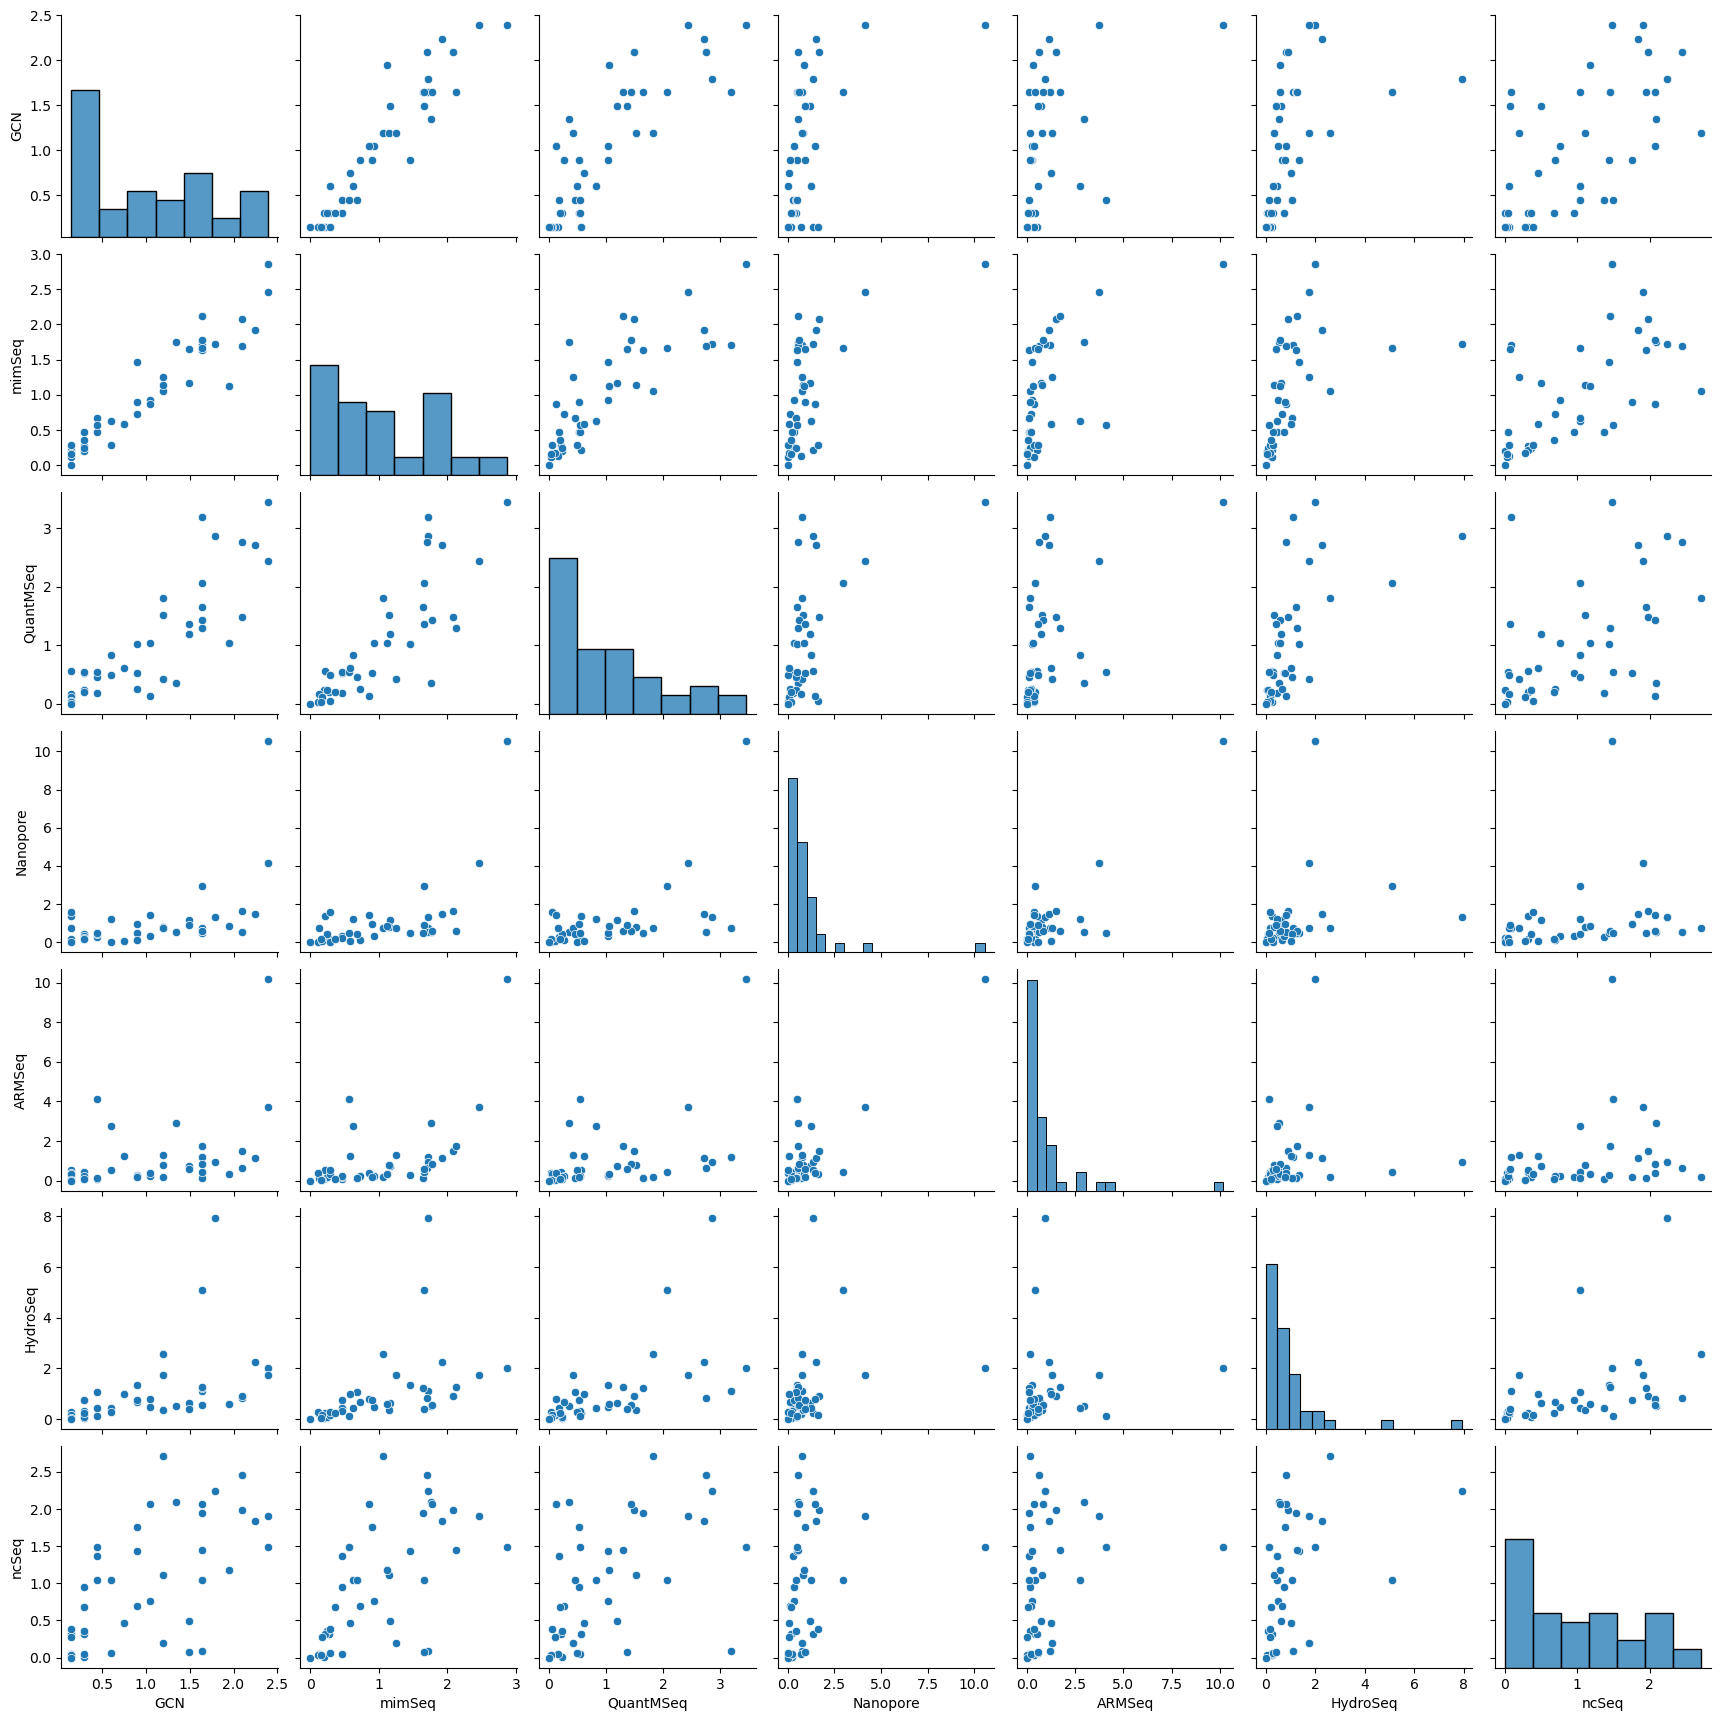

In [4]:


plot = sns.pairplot(plot_data)
#for ax in plot.axes.flatten():
#    xlab = ax.get_xlabel()
#    if len(xlab) ==0: continue
#    ax.set_xlim((0,6))

#    ylab = ax.get_ylabel()
#    if len(ylab)==0: continue
#    ax.set_ylim((0,6))
#plot.savefig('Figure files/Supp fig pairwise tRNA data.png')

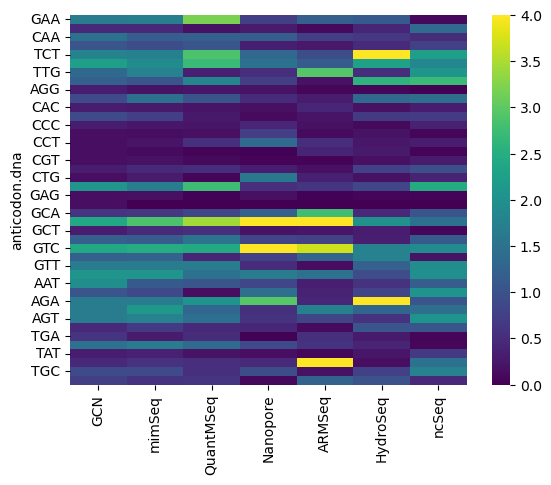

In [5]:
sns.heatmap(plot_data,cmap='viridis',vmax=4)
#plt.savefig('Figure files/tRNA_heatmap.svg')
plt.show()

In [6]:
plot_data.index

Index(['GAA', 'TAC', 'CAA', 'TAA', 'TCT', 'TTC', 'TTG', 'TTT', 'AGG', 'CCA',
       'CAC', 'CAT', 'CCC', 'CCG', 'CCT', 'CGA', 'CGT', 'CTC', 'CTG', 'CTT',
       'GAG', 'GAT', 'GCA', 'GCC', 'GCT', 'GTA', 'GTC', 'GTG', 'GTT', 'AAC',
       'AAT', 'ACG', 'AGA', 'AGC', 'AGT', 'TCC', 'TGA', 'TGG', 'TAT', 'TAG',
       'TGC', 'TGT'],
      dtype='object', name='anticodon.dna')

In [7]:
#simulate decoding times


#set up the simulator
sim = r.ribosomesimulator()
#set up simulations for each tRNA result file
codons_list = pd.read_csv('Data/tRNA data/codons.csv')
codon_list = pd.read_csv('Data/tRNA data/codon.csv')
#assemble a codon list
codons = []
for n1 in ['A','C','G','U']:
    for n2 in ['A','C','G','U']:
        for n3 in ['A','C','G','U']:
            codon = n1+n2+n3
            if codon not in ['UAA','UAG','UGA']:
                codons.append(codon)
#prepare an empty list to hold results
result_list = []
labels = []
for filename in filenames:
    tRNAs = pd.read_csv('Data/tRNA data/'+filename)  
    matrix = cg.make_matrix(tRNAs, codon_list,settings_file_name=json_path)
    concs = cg.make_concentrations(matrix, tRNAs, codon_list, concentration_col_name='Seq').to_csv(path_or_buf = None)
    sim.loadConcentrationsFromString(concs)
    file_results = []
    for codon in codons:
        sim.setCodonForSimulation(codon)
        file_results.append(sim.run_repeatedly_get_average_time(10000))
    result_list.append(file_results)
    labels.append(filename.split('_')[1])
    print('processed ' + filename)
#assemble results into a Dataframe
model_results = {'codon':codons}
for idx,label in enumerate(labels):
    model_results[label] = result_list[idx]
model_results = pd.DataFrame(model_results)
model_results = model_results.set_index('codon')
model_results = model_results[['GCN','mimSeq','QuantMSeq','Nanopore','ARMSeq','HydroSeq','ncSeq']]
model_results.to_csv('Scer_tRNA_modelling.csv')

processed N_GCN_Scer.csv
processed N_Nanopore_Scer.csv
processed N_ARMSeq_Scer.csv
processed GSE197651_ncSeq_Scer.csv
processed GSE109527_HydroSeq_Scer.csv
processed GSE198271_QuantMSeq_Scer.csv
processed GSE152621_mimSeq_Scer.csv


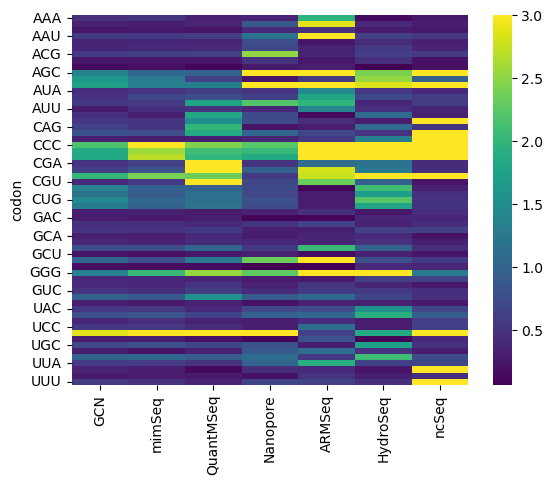

In [8]:
sns.heatmap(model_results,cmap='viridis',vmax=3)
#plt.savefig('Figure files/decoding_times_heatmap.svg')
plt.show()

In [9]:
#add RRTs
combined_data = model_results
rrt_filenames = os.listdir('Data/Experimental data/')
for rrt_filename in rrt_filenames:
    if rrt_filename[0] != '.':
        new_data = pd.read_csv('Data/Experimental data/' + rrt_filename)
        new_name = rrt_filename[:-4]
        new_data.columns = ['codon',new_name]
        combined_data = combined_data.merge(new_data,on='codon')
combined_data = combined_data.set_index('codon')

In [10]:
#fit 2D mds
mds = MDS(n_components=2,normalized_stress='auto',metric=True)
mds_data = mds.fit_transform(combined_data.T)
get_mds_clusters = DBSCAN(eps=0.2, min_samples=10).fit(mds_data)

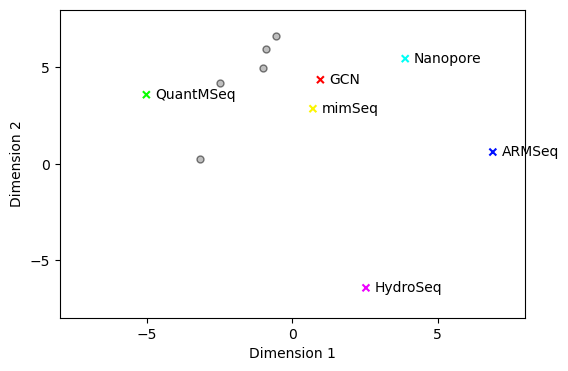

In [11]:
###Plot results

x = mds_data.T[0]
y = mds_data.T[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x[:7],y[:7],s=25,c=[1,2,3,4,5,6,7],cmap='hsv',marker='x')
ax.scatter(x[-5:],y[-5:],c='grey',edgecolor='black',s=25,alpha=0.5)
#label individual clusters with their cluster number
for idx,label in enumerate(combined_data.columns[:6]):
    if x[idx] < 10:
        ax.text(x[idx] + 0.3,y[idx],label,verticalalignment='center')
ax.set_xlim((-8,8))
ax.set_ylim((-8,8))
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_xticks([-5,0,5,])
ax.set_yticks([-5,0,5,])

plt.savefig('Figure files/tRNA dataset clusters.svg')
plt.show()
